# Setup

In [1]:
class_labels = ['Low', 'Intermediate', 'High']

In [26]:
import os
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from typing import Tuple

In [35]:
def load_features(feature_type: str, original: bool = True, return_file_indices: bool = False):
    features, labels = np.load(f"{feature_type}-features.npy"), np.load(f"{feature_type}-labels.npy").ravel()
    if not original:
        filenames = np.load(f"{feature_type}-filenames.npy", allow_pickle=True).tolist()
        clean_filenames = []
        for f in filenames:
            new_f = f.split("/")[-1]
            clean_filenames.append(new_f)
        filenames = clean_filenames
        files_to_extract = [
            "Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3"]
        for num in [2, 3, 4, 5, 9, 14, 18, 19, 23, 26, 29]:
            files_to_extract.append(
                f"Luis Suarez interview in English after being awarded November player of the month segment {num} - W.mp3")
        files_to_return = files_to_extract
        indices_adv_to_basic = []
        for extract in files_to_extract:
            indices_adv_to_basic.append(filenames.index(extract))
        files_to_extract = [
            "Musira  Rwandan athlete inability to fluently articulate himself in English segment 2 - Musira.mp3"]
        for num in [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]:
            files_to_extract.append(
                f"Musira  Rwandan athlete inability to fluently articulate himself in English segment {num} - M.mp3")
        indices_basic_to_intermediate = []
        for extract in files_to_extract:
            indices_basic_to_intermediate.append(filenames.index(extract))
        files_to_extract = [
            "Elderly Chinese street cleaner speaks fluent English segment 1 - Guy.mp3"]
        for num in [2, 3, 4, 13, 14, 15, 16, 17, 33, 34, 41, 42, 43, 44, 63, 75]:
            files_to_extract.append(
                f"Elderly Chinese street cleaner speaks fluent English segment {num} - G.mp3")
        indices_intermediate_to_advanced = []
        for extract in files_to_extract:
            indices_intermediate_to_advanced.append(filenames.index(extract))
        for ind1 in indices_adv_to_basic:
            labels[ind1] = 0
        for ind2 in indices_intermediate_to_advanced:
            labels[ind2] = 2
        for ind3 in indices_basic_to_intermediate:
            labels[ind3] = 1
        if return_file_indices:
            return features, labels, files_to_return, indices_adv_to_basic
    return features, labels

# Experiment 1

Hypothesis 1: Since the classifier isn’t learning to classify english fluency levels, but rather acting as a speaker recognition algorithm, if we label an advanced speaker’s audio fragments as “Basic”, or an intermediate speaker’s audio as “Advanced” and so forth, the classifier’s performance shouldn’t be affected.
Create a new dataset by moving 12 audio fragments from “Basic” to “Intermediate”, 17 from “Intermediate” to “Advanced”, and 12 from “Advanced” to “Basic”.
Train the model with the highest accuracy from [1] (SVM) with the original dataset, maintaining as many unchanged parameters as possible.
Find accuracy and confusion matrix to use as reference.
Train the model with the highest accuracy from [1] (SVM) with the modified dataset, maintaining as many unchanged parameters as possible.
Find accuracy and confusion matrix.
Compare the results.


In [4]:
def experiment_1(feature_type: str, model_type: str, original: bool = True):
    X, y = load_features(feature_type, original)

    # Fix random seed number
    np.random.seed(7)

    # Load the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

    if model_type == "SVM":
        # SVM classifier
        svm_clf = SVC(C=200, gamma=0.0001, kernel='rbf', decision_function_shape="ovr")

        # Fit model
        svm_clf.fit(X_train, y_train)

        # Predictions
        y_predict = svm_clf.predict(X_test)
        # Accuracy Result
        acc = svm_clf.score(X_test, y_test)
        # Accuracy Result
        print("Test accuracy = %0.4f" % acc)

        cm = confusion_matrix(y_test, y_predict)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        cm_display.plot(cmap="inferno")
    else:
        number_of_features = len(X[1])  #This is variable with each run
        number_of_classes = 3
        # Neural Network Architecture
        model = Sequential()  # Define Sequential model

        # Using relu on the first two layers and softmax on the output layer

        # 1st Layer
        #N neurons, Number_Fatures-dimensional vectors
        model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
        model.add(Dropout(0.5))

        # 2nd Layer
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))

        # 3rd Layer. Output 3 neurons corresponding the number of classes
        # The sigmoid function is used for the two-class logistic regression,
        # whereas the softmax function is used for the multiclass logistic regression
        model.add(Dense(number_of_classes, activation='softmax'))

        # Model Compilation. Loss for multi-class classification problem
        # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        # rmsprop = 'rmsprop'
        adam = 'adam'
        model.compile(loss='categorical_crossentropy',
                      optimizer=adam,  #rmsprop better than sgd
                      metrics=['accuracy'])

        # Convert labels to categorical one-hot encoding
        y_train = to_categorical(y_train - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix
        y_test = to_categorical(y_test - 1, num_classes=number_of_classes)

        # Train and test
        history = model.fit(X_train, y_train, epochs=100, batch_size=64)  #batch 32, 64, 128, 256, 512

        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()

        score, acc = model.evaluate(X_test, y_test, batch_size=64)
        print('Test accuracy = ', acc)

        Y_pred = model.predict(X_test)
        y_predict_non_category = [np.argmax(t) for t in Y_pred]
        y_test_non_category = [np.argmax(t) for t in y_test]
        cm = confusion_matrix(y_test_non_category, y_predict_non_category)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        cm_display.plot(cmap="inferno")

## Original dataset/MFCC/SVM

Test accuracy = 0.9369


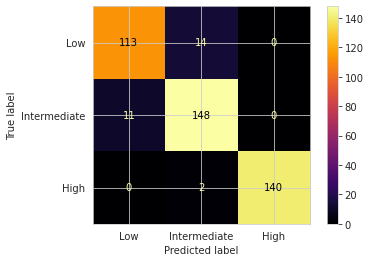

In [122]:
experiment_1(feature_type="mfcc", model_type="SVM", original=True)

## Original dataset/MFCC/MLP

Epoch 1/100
16/16 [==============================] - 4s 23ms/step - loss: 44.1910 - accuracy: 0.3675
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 33.1836 - accuracy: 0.3343
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 21.2752 - accuracy: 0.3936
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 14.8312 - accuracy: 0.3956
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 10.7102 - accuracy: 0.4157
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 8.7675 - accuracy: 0.4076
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 6.3418 - accuracy: 0.4468
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 5.1115 - accuracy: 0.4147
Epoch 9/100
16/16 [==============================] - 0s 9ms/step - loss: 4.4621 - accuracy: 0.4327
Epoch 10/100
16/16 [==============================] - 0s 8ms/step - loss: 3.6002 - accuracy: 0.4518

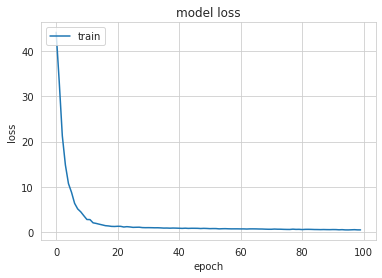

7/7 [==============================] - 1s 10ms/step - loss: 0.3652 - accuracy: 0.8808
Test accuracy =  0.8808411359786987
14/14 [==============================] - 0s 6ms/step


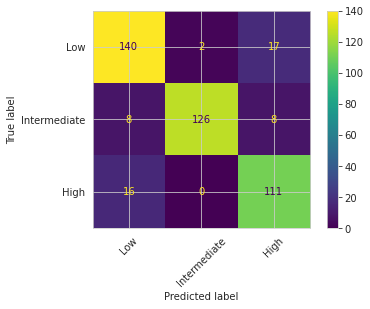

In [123]:
experiment_1(feature_type="mfcc", model_type="MLP", original=True)

## Original dataset/Yu embeddings/SVM

Test accuracy = 0.5421


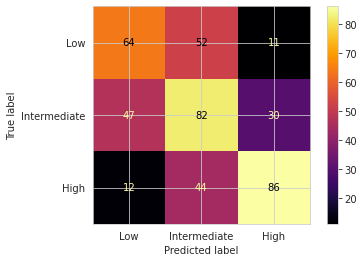

In [125]:
experiment_1(feature_type="yu", model_type="SVM", original=True)

## Original dataset/Yu embeddings/MLP

Epoch 1/100
16/16 [==============================] - 3s 9ms/step - loss: 1.3362 - accuracy: 0.3263
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 1.0923 - accuracy: 0.4468
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 1.0743 - accuracy: 0.4378
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0145 - accuracy: 0.4970
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9939 - accuracy: 0.4859
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9707 - accuracy: 0.5311
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9733 - accuracy: 0.5171
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9634 - accuracy: 0.5231
Epoch 9/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9524 - accuracy: 0.5261
Epoch 10/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9353 - accuracy: 0.5090
Epoch 11

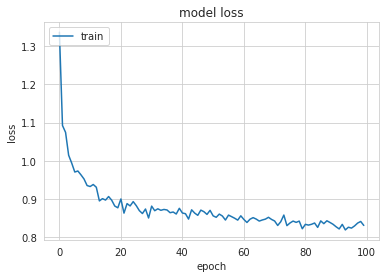

7/7 [==============================] - 0s 7ms/step - loss: 0.9950 - accuracy: 0.5678
Test accuracy =  0.5677570104598999
14/14 [==============================] - 0s 3ms/step


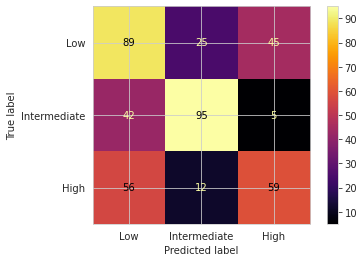

In [126]:
experiment_1(feature_type="yu", model_type="MLP", original=True)

## Modified dataset/MFCC/SVM

[1167, 1171, 1175, 1176, 1177, 1178, 1168, 1169, 1170, 1172, 1173, 1174]
[431, 432, 433, 434, 435, 436, 437, 426, 427, 428, 429, 430]
[931, 937, 938, 941, 932, 933, 934, 935, 936, 939, 940, 942, 943, 944, 945, 946, 947]
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
Test accuracy = 0.9252


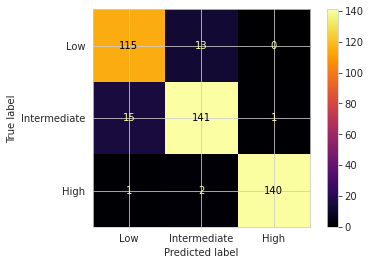

In [150]:
experiment_1(feature_type="mfcc", model_type="SVM", original=False)

## Modified dataset/MFCC/MLP

[1167, 1171, 1175, 1176, 1177, 1178, 1168, 1169, 1170, 1172, 1173, 1174]
[431, 432, 433, 434, 435, 436, 437, 426, 427, 428, 429, 430]
[931, 937, 938, 941, 932, 933, 934, 935, 936, 939, 940, 942, 943, 944, 945, 946, 947]
Epoch 1/100
16/16 [==============================] - 4s 21ms/step - loss: 55.0890 - accuracy: 0.2912
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 31.6037 - accuracy: 0.3373
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 20.1533 - accuracy: 0.3755
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 15.5684 - accuracy: 0.3484
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 10.3412 - accuracy: 0.3996
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 8.1807 - accuracy: 0.3936
Epoch 7/100
16/16 [==============================] - 0s 18ms/step - loss: 6.1050 - accuracy: 0.4247
Epoch 8/100
16/16 [==============================] - 0s 20ms/step - loss: 5.4

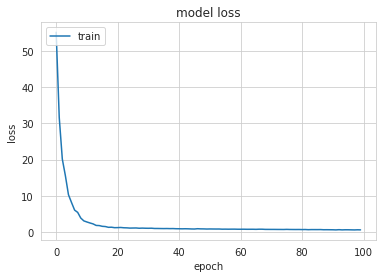

7/7 [==============================] - 0s 7ms/step - loss: 0.5334 - accuracy: 0.8388
Test accuracy =  0.8387850522994995
14/14 [==============================] - 0s 3ms/step


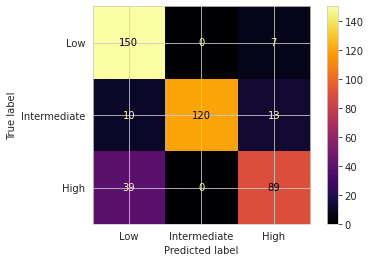

In [144]:
experiment_1(feature_type="mfcc", model_type="MLP", original=False)

## Modified dataset/Yu features/SVM

[1147, 1195, 1192, 1191, 1194, 1188, 1141, 1140, 1196, 1193, 1189, 1190]
[436, 434, 430, 433, 431, 432, 435, 376, 377, 371, 370, 437]
[962, 957, 954, 952, 958, 956, 960, 955, 959, 953, 951, 949, 948, 945, 947, 946, 950]
Test accuracy = 0.5421


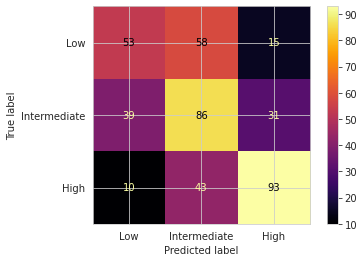

In [145]:
experiment_1(feature_type="yu", model_type="SVM", original=False)

## Modified dataset/Yu features/MLP

[1147, 1195, 1192, 1191, 1194, 1188, 1141, 1140, 1196, 1193, 1189, 1190]
[436, 434, 430, 433, 431, 432, 435, 376, 377, 371, 370, 437]
[962, 957, 954, 952, 958, 956, 960, 955, 959, 953, 951, 949, 948, 945, 947, 946, 950]
Epoch 1/100
16/16 [==============================] - 2s 10ms/step - loss: 1.2455 - accuracy: 0.3745
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 1.1152 - accuracy: 0.4237
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0464 - accuracy: 0.4578
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0261 - accuracy: 0.4859
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0283 - accuracy: 0.4880
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9934 - accuracy: 0.4990
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9628 - accuracy: 0.5321
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9844 - accu

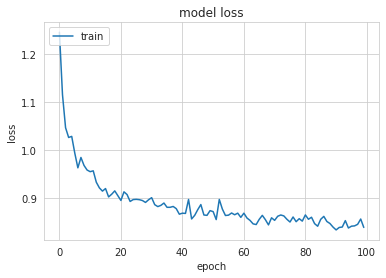

7/7 [==============================] - 0s 7ms/step - loss: 1.0839 - accuracy: 0.5537
Test accuracy =  0.5537382960319519
14/14 [==============================] - 0s 3ms/step


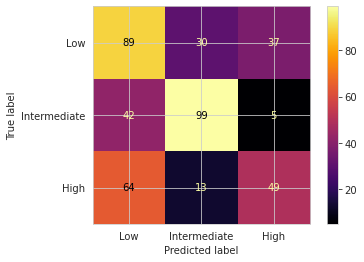

In [146]:
experiment_1(feature_type="yu", model_type="MLP", original=False)

## Original dataset/Lexical-prosodic features/SVM


Test accuracy = 0.5093


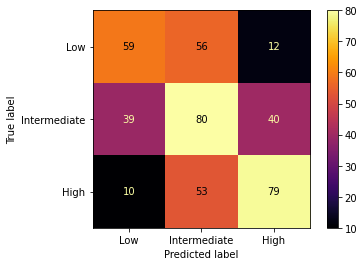

In [37]:
experiment_1(feature_type="lexical-prosodic", model_type="SVM", original=True)

## Original dataset/Lexical-prosodic features/MLP

Epoch 1/100
16/16 [==============================] - 1s 9ms/step - loss: 1.2663 - accuracy: 0.3484
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 1.1527 - accuracy: 0.3765
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0852 - accuracy: 0.4177
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 1.0334 - accuracy: 0.4498
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 1.0280 - accuracy: 0.4317
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 1.0189 - accuracy: 0.4578
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9711 - accuracy: 0.4859
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9748 - accuracy: 0.4659
Epoch 9/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9543 - accuracy: 0.5131
Epoch 10/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9526 - accuracy: 0.5000
Epoch 11

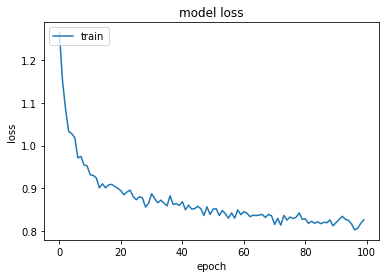

7/7 [==============================] - 0s 6ms/step - loss: 1.0067 - accuracy: 0.5187
Test accuracy =  0.5186915993690491
14/14 [==============================] - 0s 5ms/step


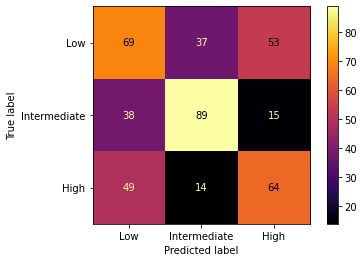

In [25]:
experiment_1(feature_type="lexical-prosodic", model_type="MLP", original=True)

## Modified dataset/Lexical-prosodic features/SVM

In [ ]:
experiment_1(feature_type="lexical-prosodic", model_type="SVM", original=False)

## Modified dataset/Lexical-prosodic features/MLP

In [ ]:
experiment_1(feature_type="lexical-prosodic", model_type="MLP", original=False)

# Experiment 2

## MFCCs/SVM

In [31]:
def experiment_2(feature_type: str, model_type: str):
    X, y, files_to_extract, indices = load_features(feature_type=feature_type, original=False, return_file_indices=True)
    number_of_features = len(X[1])  #This is variable with each run
    number_of_classes = 3
    xx = 0
    for ind in indices:
        print(ind, files_to_extract[xx], class_labels[y[ind]])
        xx += 1
        vals = []
        valsout = []
        arr = X
        arrout = y
        for i in range(arr.shape[0]):
            if i != ind:
                vals.append(arr[i])
                valsout.append(arrout[i])
        newX = np.array(vals)
        print(newX.shape)
        newY = np.array(valsout)
        print(newY.shape)

        # Fix random seed number
        np.random.seed(7)

        if model_type == "SVM":
            # SVM classifier
            svm_clf = SVC(C=200, gamma=0.0001, kernel='rbf', decision_function_shape="ovr")

            # Fit model
            svm_clf.fit(newX, newY)

            pred_arr = svm_clf.predict(X[ind].reshape(1, -1))
            print("Pred: ", class_labels[pred_arr[0]])
        else:
            # Neural Network Architecture
            model = Sequential()  # Define Sequential model

            # Using relu on the first two layers and softmax on the output layer

            # 1st Layer
            #N neurons, Number_Fatures-dimensional vectors
            model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
            model.add(Dropout(0.5))

            # 2nd Layer
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.5))

            # 3rd Layer. Output 3 neurons corresponding the number of classes
            # The sigmoid function is used for the two-class logistic regression,
            # whereas the softmax function is used for the multiclass logistic regression
            model.add(Dense(number_of_classes, activation='softmax'))

            # Model Compilation. Loss for multi-class classification problem
            # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            # rmsprop = 'rmsprop'
            adam = 'adam'
            model.compile(loss='categorical_crossentropy',
                          optimizer=adam,  #rmsprop better than sgd
                          metrics=['accuracy'])

            # Convert labels to categorical one-hot encoding
            newY = to_categorical(newY - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix

            # Train and test
            model.fit(newX, newY, epochs=100, batch_size=64, verbose=0)  #batch 32, 64, 128, 256, 512

            pred_arr = model(X[ind].reshape(1, -1))
            print("Pred: ", class_labels[np.argmax(pred_arr, 1)[0]])

In [32]:
experiment_2(feature_type="mfcc", model_type="SVM")

[2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0]
1167 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1171 Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Intermediate
1175 Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1176 Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1177 Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Intermediate
1178 Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1168 Luis Suarez interview in English after being awarded November player of the month segme

## MFCCs/MLP

In [33]:
experiment_2(feature_type="mfcc", model_type="MLP")

[2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0]
1167 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 23)
(1423,)


KeyboardInterrupt: 

## Yu features/SVM

In [36]:
experiment_2(feature_type="yu", model_type="SVM")

1147 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1195 Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1192 Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1191 Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1194 Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1188 Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1141 Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1140 Luis Suare

## Yu features/MLP

In [14]:
experiment_2(feature_type="yu", model_type="MLP")

[1147, 1195, 1192, 1191, 1194, 1188, 1141, 1140, 1196, 1193, 1189, 1190]
Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November pla

## Lexical-prosodic features/SVM

In [17]:
experiment_2(feature_type="lexical-prosodic", model_type="SVM")

[1182, 1179, 1177, 1172, 1168, 1175, 1181, 1183, 1186, 1188, 1185, 1178]
Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 16)
(1423,)
Pred:  High
Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  High
Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  High
Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  High
Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  Low
Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  High
Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 16

## Lexical-prosodic features/MLP

In [24]:
experiment_2(feature_type="lexical-prosodic", model_type="MLP")

[1182, 1179, 1177, 1172, 1168, 1175, 1181, 1183, 1186, 1188, 1185, 1178]
Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 16)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  Low
Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 16)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of th